# Tutorial 6b: Frequentist hypothesis testing

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t6b_frequentist_hypothesis_testing.ipynb).*

In [1]:
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In the [previous tutorial](t6a_frequentist_parameter_estimation.html), we studied parameter estimation from a frequentist perspective.  We saw that if we are trying to estimate a parameter from a probability distribution, we should try to define an unbiased estimator for that parameter based on the expectation values of the distribution.  Beyond that, we saw that we can do computational "experiments" to get samples from the repeated hypothetical experiments that define frequentist probability.

In this tutorial, we will apply this same computational experimental approach to do hypothesis testing.  It is important to note that frequentist hypothesis testing is different from Bayesian model selection, in that in the frequentist hypothesis tests, we will only consider how probable it is to get the observed data under a specific hypothesis, often called the **null hypothesis**.  We will not assess other hypotheses or compare them.  Remember that the probability of a hypothesis being true is not something that makes any sense to a frequentist.

## The data set
We will again use the data from Reeves, et al. for this tutorial.  Let's load them in again.

In [2]:
# Load data into DataFrame
file_name = '../data/reeves_et_al/reeves_gradient_width_various_methods.csv'
df_fly = pd.read_csv(file_name, comment='#', header=[0, 1])

# Get columns we want
fly_wt = df_fly['wt']['cross-sections'].dropna().values 
fly_venus = df_fly['dl1/+; dl-venus/+']['anti-Dorsal'].dropna().values

## Hypothesis tests
Though there are many kind of frequentist hypothesis tests, we will focus on the most often used type of test.  The idea here is to quantify the size of the effect of an experiment with some test statistic (such as a mean).  Then we propose a **null hypothesis** which says that the effect is not real.  We then compute the probability of observing a value of the test statistic that is more extreme that the one we measured if the null hypothesis is true.  This is called a **p-value**.  If the p-value is small, the effect is said to be **statistically significant**.

We will go through this process first to test if the dorsal gradient width in wild type is different from that in the Venus fusion.  The strategy is to computationally do the experiment many times over with according to the null hypothesis and count the results that show the effect size we observed experimentally.

### Are the means different?
For our test statistic, we will use the mean of the gradient width.  We estimated the means in [the last tutorial](t6a_frequentist_parameter_estimation.html).

In [3]:
# Mean and variance of Dorsal gradient widths
mu_wt = fly_wt.mean()
var_wt = fly_wt.var(ddof=1)

mu_venus = fly_venus.mean()
var_venus = fly_venus.var(ddof=1)

# Print results
print("""
           µ         σ          n
        ---------------------------
WT      {0:.4f}     {2:.4f}      {4:d}
Venus   {1:.4f}     {3:.4f}       {5:d}
""".format(mu_wt, mu_venus, np.sqrt(var_wt), np.sqrt(var_venus), 
           len(fly_wt), len(fly_venus)))


           µ         σ          n
        ---------------------------
WT      0.1485     0.0161      152
Venus   0.1605     0.0108       29



The question now is whether we could get a mean that is so different if the WT and Venus were exactly the same.  So, our null hypothesis is that there is no difference between WT and Venus fusion flies.  We then repeat the experiment under this hypothesis.  To do this, we put all them measurements together, scramble them, and then choose 152 to be in one set and 29 in the other.  We compute the absolute value of the difference of the means.  We do this over and over again.

In [4]:
def permute_sample(x, y, stat_fun, args=(), n_trials=1000):
    """
    Considered two arrays `x` and `y` as one and then selects
    random samples out of the combined array the same size as
    the original `x` and `y`.  The computes test statistic for each
    sample.
    """
    # Array to store samples
    samples = np.empty(n_trials)

    # Put the two data sets together
    vals = np.concatenate((x, y))
    
    for i in range(n_trials):
        # Permute and compute difference in means
        vals = np.random.permutation(vals)
        samples[i] = stat_fun(vals[:len(x)], vals[len(x):], *args)
        
    return samples

def p_value_from_samples(samples, actual, greater_or_less='greater'):
    """
    Compute probability that actual values if either greater than
    or less than samples value.
    """
    
    # Compute p-value
    if greater_or_less == 'greater':
        return np.sum(samples >= actual) / len(samples)
    else:
        return np.sum(samples <= actual) / len(samples)

Let's do the test to see what the probability of getting the observed absolute difference in means is.

In [5]:
# Function for absolute value of difference in means
def mean_diff(x, y, return_abs=False):
    diff = y.mean() - x.mean()
    if return_abs:
        return np.abs(diff)
    return diff

# Get samples
samples = permute_sample(fly_wt, fly_venus, mean_diff, args=(True,), 
                         n_trials=100000)

# Compute p-value
p = p_value_from_samples(samples, mean_diff(fly_wt, fly_venus, True))
print('p-value =', p)

p-value = 0.00017


So, we get a p-value of about 0.0002, which suggests that there is a low chance of observing the same mean under the null hypothesis, which again is that the same process is generating the gradients.  This p-value is low, so we would say there is a statistically significant difference between the two means.

We can see this more clearly by plotting the CDF of the samples.

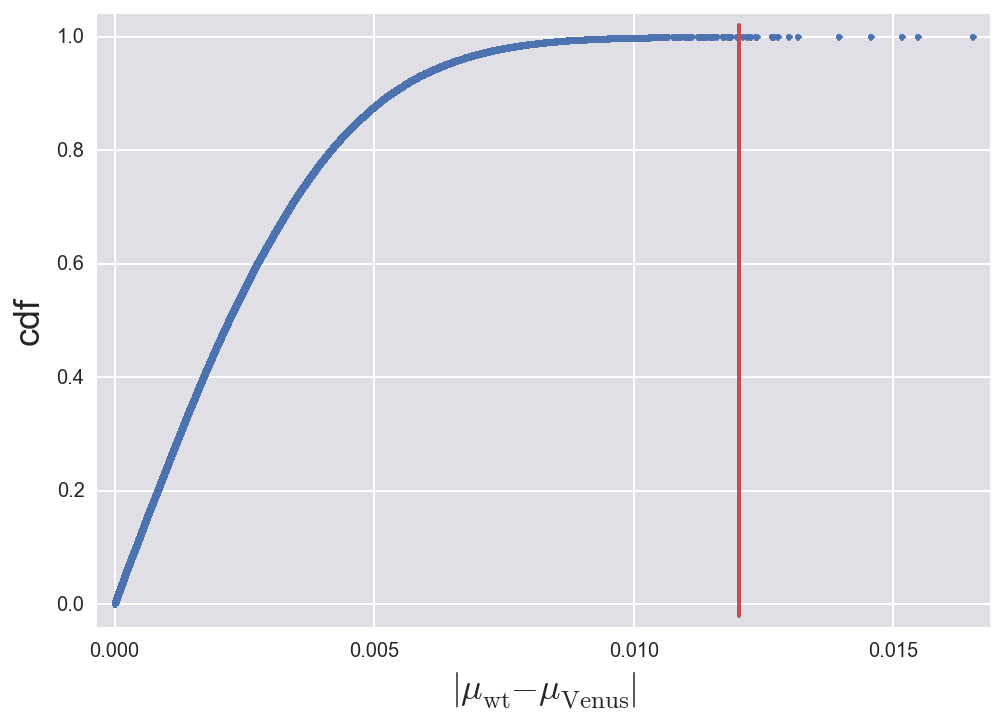

In [6]:
# Make the CDF
x = np.sort(samples)
y = np.arange(len(samples)) / len(samples)
plt.plot(x, y, '.')
plt.margins(0.02)
plt.xlabel(r'$|\mu_\mathrm{wt} - \mu_{\mathrm{Venus}}|$')
plt.ylabel('cdf')

# Plot the true difference
plt.plot(mean_diff(fly_wt, fly_venus, True) * np.array([1, 1]),
         plt.gca().axes.get_ylim(), '-', color=sns.color_palette()[2])

We see that very few samples occur with a mean as big as we are seeing, suggesting that this is very unlikely under the null hypothesis.

### Are the fill-in-the-blank different?
We can perform this type of permutation test with any statistic we are interested in.  Let's try medians.

In [7]:
def median_diff(x, y, return_abs=False):
    diff = np.median(y) - np.median(x)
    if return_abs:
        return np.abs(diff)
    return diff
   
# Get samples
samples_median = permute_sample(fly_wt, fly_venus, median_diff, args=(True,),
                                n_trials=100000)

# Compute p-value
p = p_value_from_samples(samples_median, median_diff(fly_wt, fly_venus, True))
print('median p-value =', p)

median p-value = 0.00333


Or with the variance.

In [8]:
def variance_diff(x, y, return_abs=False):
    diff = y.var() - x.var()
    if return_abs:
        return np.abs(diff)
    return diff

# Get samples
samples_var = permute_sample(fly_wt, fly_venus, variance_diff, args=(True,),\
                             n_trials=100000)

# Compute p-value
p = p_value_from_samples(samples_var, variance_diff(fly_wt, fly_venus, True))
print('variance p-value =', p)

variance p-value = 0.02594


We see that while it is unlikely to get the same difference in median under the null hypothesis, there is some chance we could get difference in variance.

We can also check **Cohen's d**, a standard deviation weighted effect size we discussed in class.

In [9]:
def cohen_d(x, y, return_abs=False):
    """
    Cohen's d
    """
    diff = y.mean() - x.mean()
    pooled_variance = (len(x) * x.var() + len(y) * y.var()) / (len(x) + len(y))

    if return_abs:
        return np.abs(diff) / np.sqrt(pooled_variance)
    return diff / np.sqrt(pooled_variance)

# Get samples
samples_d = permute_sample(fly_wt, fly_venus, cohen_d, args=(True,), 
                           n_trials=100000)

# Compute p-value
p = p_value_from_samples(samples_d, cohen_d(fly_wt, fly_venus))
print('variance p-value =', p)

variance p-value = 0.00017


Again, we would report this results as "statistically significant."

### One-sided versus two-sided
So far, we have looked at the absolute value of the difference between parameters.  We could just look at the difference of the respective statistics.  We might get different results.

In [10]:
# Compute p-values
samples = permute_sample(fly_wt, fly_venus, mean_diff, n_trials=100000)
p = p_value_from_samples(samples, mean_diff(fly_wt, fly_venus))
print('Mean p-value =', p)

samples = permute_sample(fly_wt, fly_wt, median_diff, n_trials=100000)
p = p_value_from_samples(samples, median_diff(fly_wt, fly_venus))
print('Median p-value =', p)

samples = permute_sample(fly_venus, fly_wt, variance_diff, n_trials=100000)
p = p_value_from_samples(samples, variance_diff(fly_venus, fly_wt))
print('Variance p-value =', p)

samples = permute_sample(fly_wt, fly_venus, cohen_d, n_trials=100000)
p = p_value_from_samples(samples, cohen_d(fly_wt, fly_venus))
print('Cohen-d p-value =', p)

Mean p-value = 6e-05
Median p-value = 0.0
Variance p-value = 0.00756
Cohen-d p-value = 4e-05


The p-values have done down when we are not looking at absolute values.  I.e., we are not looking just to see if the effect magnitude is expected from the null hypothesis, but also the sign of the effect.

### Warnings about hypothesis tests
There are many.

1. An effect being statistically significant does not mean the effect is significant in practice or even important.  It only means exactly what it is defined to mean: an effect is unlikely to have happened by chance under the null hypothesis.  Far more important is the **effect size**.
2. The p-value is **not** the probability that the null hypothesis is true.  It is the probability of observing the test statistic being more extreme than what was measured if the null hypothesis is true.  I.e., it is  $P(\text{more extreme than observed test stat}\mid H_0)$ and **not** $P(H_0\mid \text{more extreme than observed test stat})$.  We actually want the latter, and the p-value is often erroneously interpreted as the latter to great peril.
3. Null hypothesis significance testing does not say anything about alternative hypotheses.  Rejection of the null hypothesis does not mean acceptance of any other hypotheses.
4. P-values are not very reproducible, as we will see in the homework when we do "dance of the p-values."
5. Rejecting a null hypothesis is also kind of odd, considering you computed $P(\text{observed test statistic value}\mid H_0)$.  This, along with point 4, means that the p-value better really low for you to reject the null hypothesis.
6. Throughout the literature, you will see null hypothesis testing when the null hypothesis is not relevant at all.  People compute p-values because that's what they are supposed to do.  The Dorsal gradient might be an example: of course the gradients will be different; we have made a big perturbation.  Again, it gets to the point that **effect size** is waaaaay more important that a null hypothesis significance test.

I should also mention that there are names for many of the tests we did in this tutorial, and there are countless other tests.  Many of these tests have analytical forms and can be rapidly computed.  Most are included in `scipy.stats`.  I have chosen to present a method of hypothesis testing that is intuitive with the frequentist definition of probability front and center.  It also allows you to design your own tests that fit a null hypothesis that you are interested in that might not be "off-the-shelf."

That said, given all these problems with p-values, I generally advocate for their abandonment.  They seldom answer the question scientists are asking and lead to great confusion.